# Week 13: Inspecting gradients for the GRU-pair SNLI model

In this assignment we'll inspect a GRU RNN-based model for SNLI.

## Setup

You'll need to download and unzip SNLI, which you can find [here](http://nlp.stanford.edu/projects/snli/). Set `snli_home` below to point to it. The following block of code loads it.

In [4]:
snli_home = '../snli_1.0'

import re
import random
import json

LABEL_MAP = {
    "entailment": 0,
    "neutral": 1,
    "contradiction": 2
}

def load_snli_data(path):
    data = []
    with open(path) as f:
        for line in f:
            loaded_example = json.loads(line)
            if loaded_example["gold_label"] not in LABEL_MAP:
                continue
            loaded_example["label"] = LABEL_MAP[loaded_example["gold_label"]]
            data.append(loaded_example)
        random.seed(1)
        random.shuffle(data)
    return data
     
training_set = load_snli_data(snli_home + '/snli_1.0_train.jsonl')
dev_set = load_snli_data(snli_home + '/snli_1.0_dev.jsonl')
test_set = load_snli_data(snli_home + '/snli_1.0_test.jsonl')

# Note: Unlike with k-nearest neighbors, evaluation here should be fast, and we don't need to
# trim down the dev and test sets. 

Next, we'll convert the data to index vectors in the same way that we've done for in-class exercises with RNN-based sentiment models. A few notes:

- We use a sequence length of only 10, which is short enough that we're truncating a large fraction of sentences.
- Tokenization is easy here because we're relying on the output of a parser (which does tokenization as part of parsing), just as with the SST corpus that we've been using until now. Note that we use the 'sentence1_binary_parse' field of each example rather than the human-readable 'sentence1'.
- We're using a moderately large vocabulary (for a class exercise) of about 12k words.

In [5]:
SEQ_LEN = 10

import collections
import numpy as np

def sentences_to_padded_index_sequences(datasets):
    '''Annotates datasets with feature vectors.'''
    
    PADDING = "<PAD>"
    UNKNOWN = "<UNK>"
    
    # Extract vocabulary
    def tokenize(string):
        string = re.sub(r'\(|\)', '', string)
        return string.lower().split()
    
    word_counter = collections.Counter()
    for example in datasets[0]:
        word_counter.update(tokenize(example['sentence1_binary_parse']))
        word_counter.update(tokenize(example['sentence2_binary_parse']))
        
    vocabulary = set([word for word in word_counter if word_counter[word] > 10])
    vocabulary = list(vocabulary)
    vocabulary = [PADDING, UNKNOWN] + vocabulary
        
    word_indices = dict(zip(vocabulary, range(len(vocabulary))))
    indices_to_words = {v: k for k, v in word_indices.items()}
        
    for i, dataset in enumerate(datasets):
        for example in dataset:
            for sentence in ['sentence1_binary_parse', 'sentence2_binary_parse']:
                example[sentence + '_index_sequence'] = np.zeros((SEQ_LEN), dtype=np.int32)

                token_sequence = tokenize(example[sentence])
                padding = SEQ_LEN - len(token_sequence)

                for i in range(SEQ_LEN):
                    if i >= padding:
                        if token_sequence[i - padding] in word_indices:
                            index = word_indices[token_sequence[i - padding]]
                        else:
                            index = word_indices[UNKNOWN]
                    else:
                        index = word_indices[PADDING]
                    example[sentence + '_index_sequence'][i] = index
    return indices_to_words, word_indices
    
indices_to_words, word_indices = sentences_to_padded_index_sequences([training_set, dev_set, test_set])

In [6]:
print training_set[6]
print len(word_indices)

{u'annotator_labels': [u'contradiction'], u'sentence2_parse': u'(ROOT (NP (NP (NNS People)) (PP (IN on) (NP (DT a) (NN bike))) (PP (IN on) (NP (DT a) (NN beach))) (. .)))', u'sentence1_binary_parse': u'( ( Five men ) ( ( are ( ( ( playing ( musical instruments ) ) together ) ( on ( a stage ) ) ) ) . ) )', u'captionID': u'2430018178.jpg#1', 'sentence1_binary_parse_index_sequence': array([ 6060, 11028,  7751,  3574, 10502,  3750, 10482,  4668,  2910,   472], dtype=int32), 'label': 2, u'sentence2_binary_parse': u'( ( ( People ( on ( a bike ) ) ) ( on ( a beach ) ) ) . )', u'pairID': u'2430018178.jpg#1r1c', u'sentence2': u'People on a bike on a beach.', u'sentence1_parse': u'(ROOT (S (NP (CD Five) (NNS men)) (VP (VBP are) (VP (VBG playing) (NP (JJ musical) (NNS instruments)) (ADVP (RB together)) (PP (IN on) (NP (DT a) (NN stage))))) (. .)))', 'sentence2_binary_parse_index_sequence': array([    0,     0,   592, 10482,  4668,  3030, 10482,  4668,  3180,   472], dtype=int32), u'gold_label': u

Now we load GloVe. You'll need the same file that you used for the in-class exercise on word embeddings.

In [7]:
glove_home = '../'
words_to_load = 25000

with open(glove_home + 'glove.6B.50d.txt') as f:
    loaded_embeddings = np.zeros((len(word_indices), 50), dtype='float32')
    for i, line in enumerate(f):
        if i >= words_to_load: 
            break
        
        s = line.split()
        if s[0] in word_indices:
            loaded_embeddings[word_indices[s[0]], :] = np.asarray(s[1:])

Now we set up an evaluation function as before.

In [8]:
def evaluate_classifier(classifier, eval_set):
    correct = 0
    hypotheses = classifier(eval_set)
    for i, example in enumerate(eval_set):
        hypothesis = hypotheses[i]
        if hypothesis == example['label']:
            correct += 1        
    return correct / float(len(eval_set))

## Running the model

This model is a slightly modified verison of the one I had you build for HW5. It is somewhat smaller, and the word embeddings that we use are now treated as member variables (`self.premise_embs` and `self.hypothesis_embs`) so we can access them later. 

You shouldn't need to edit it—just go ahead and run it for a few epochs.

In [126]:
import tensorflow as tf

In [48]:
class RNNEntailmentClassifier:
    def __init__(self, vocab_size, sequence_length):
        # Define the hyperparameters
        self.learning_rate = 1.0  # Should be about right
        self.training_epochs = 5  # How long to train for - chosen to fit within class time
        self.display_epoch_freq = 1  # How often to test and print out statistics
        self.dim = 16  # The dimension of the hidden state of the RNN
        self.combination_dim = 16  # The dimension of the hidden state of the combination layer
        self.embedding_dim = 50  # The dimension of the learned word embeddings
        self.batch_size = 128  # Somewhat arbitrary - can be tuned, but often tune for speed, not accuracy
        self.vocab_size = vocab_size  # Defined by the file reader above
        self.sequence_length = sequence_length  # Defined by the file reader above
        
        # Define the parameters
        self.E = tf.Variable(loaded_embeddings)
        
        self.W_rnn = tf.Variable(tf.random_normal([self.embedding_dim + self.dim, self.dim], stddev=0.1))
        self.b_rnn = tf.Variable(tf.random_normal([self.dim], stddev=0.1))
        
        self.W_r = tf.Variable(tf.random_normal([self.embedding_dim + self.dim, self.dim], stddev=0.1))
        self.b_r = tf.Variable(tf.random_normal([self.dim], stddev=0.1))
        
        self.W_z = tf.Variable(tf.random_normal([self.embedding_dim + self.dim, self.dim], stddev=0.1))
        self.b_z = tf.Variable(tf.random_normal([self.dim], stddev=0.1))
        
        self.W_comb = tf.Variable(tf.random_normal([4 * self.dim, self.combination_dim], stddev=0.1))
        self.b_comb = tf.Variable(tf.random_normal([self.combination_dim], stddev=0.1))
        
        self.W_cl = tf.Variable(tf.random_normal([self.combination_dim, 3], stddev=0.1))
        self.b_cl = tf.Variable(tf.random_normal([3], stddev=0.1))
        
        # Define the placeholders
        self.premise_x = tf.placeholder(tf.int32, [None, self.sequence_length])
        self.hypothesis_x = tf.placeholder(tf.int32, [None, self.sequence_length])
        self.y = tf.placeholder(tf.int32, [None])
        
        # Define one step of the RNN
        def step(x, h_prev):
            emb = tf.nn.embedding_lookup(self.E, x)
            emb_h_prev = tf.concat(1, [emb, h_prev])
            z = tf.nn.sigmoid(tf.matmul(emb_h_prev, self.W_z)  + self.b_z)
            r = tf.nn.sigmoid(tf.matmul(emb_h_prev, self.W_r)  + self.b_r)
            emb_r_h_prev = tf.concat(1, [emb, r * h_prev])
            h_tilde = tf.nn.tanh(tf.matmul(emb_r_h_prev, self.W_rnn)  + self.b_rnn)
            h = (1. - z) * h_prev + z * h_tilde
            return h, emb

        # Split up the inputs into individual tensors
        self.x_premise_slices = tf.split(1, self.sequence_length, self.premise_x)
        self.x_hypothesis_slices = tf.split(1, self.sequence_length, self.hypothesis_x)
        
        self.h_zero = tf.zeros(tf.pack([tf.shape(self.premise_x)[0], self.dim]))
        
        # Unroll the first RNN
        h_prev_premise = self.h_zero
        self.premise_embs = []
        for t in range(self.sequence_length):
            x_t = tf.reshape(self.x_premise_slices[t], [-1])
            h_prev_premise, emb = step(x_t, h_prev_premise)
            self.premise_embs.append(emb)
        self.premise_vector = h_prev_premise
        
        # Unroll the second RNN
        h_prev_hypothesis = self.h_zero
        self.hypothesis_embs = []
        for t in range(self.sequence_length):
            x_t = tf.reshape(self.x_hypothesis_slices[t], [-1])
            h_prev_hypothesis, emb = step(x_t, h_prev_hypothesis)
            self.hypothesis_embs.append(emb)
        self.hypothesis_vector = h_prev_hypothesis     
            
        # Compute a penultimate ReLU layer
        pair_features = tf.concat(1, [self.premise_vector,
                                      self.hypothesis_vector, 
                                      self.premise_vector * self.hypothesis_vector,
                                      self.premise_vector - self.hypothesis_vector])
        combination_layer = tf.nn.relu(tf.matmul(pair_features, self.W_comb) + self.b_comb)    
        
        # Compute the logits
        self.logits = tf.matmul(combination_layer, self.W_cl) + self.b_cl
        
        # Define the cost function (here, the softmax exp and sum are built in)
        self.total_cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(self.logits, self.y))
        
        # This  performs the main SGD update equation with gradient clipping
        optimizer_obj = tf.train.GradientDescentOptimizer(learning_rate=self.learning_rate)
        gvs = optimizer_obj.compute_gradients(self.total_cost)
        capped_gvs = [(tf.clip_by_norm(grad, 5.0), var) for grad, var in gvs if grad is not None]
        self.optimizer = optimizer_obj.apply_gradients(capped_gvs)
        
        # Create an operation to fill zero values in for W and b
        self.init = tf.initialize_all_variables()
        
        # Create a placeholder for the session that will be shared between training and evaluation
        self.sess = None
        
    def train(self, training_data, dev_data):
        def get_minibatch(dataset, start_index, end_index):
            indices = range(start_index, end_index)
            premise_vectors = np.vstack([dataset[i]['sentence1_binary_parse_index_sequence'] for i in indices])
            hypothesis_vectors = np.vstack([dataset[i]['sentence2_binary_parse_index_sequence'] for i in indices])
            labels = [dataset[i]['label'] for i in indices]
            return premise_vectors, hypothesis_vectors, labels
        
        self.sess = tf.Session()
        
        self.sess.run(self.init)
        print 'Training.'

        # Training cycle
        for epoch in range(self.training_epochs):
            random.shuffle(training_data)
            avg_cost = 0.
            total_batch = int(len(training_data) / self.batch_size)
            
            # Loop over all batches in epoch
            for i in range(total_batch):
                # Assemble a minibatch of the next B examples
                minibatch_premise_vectors, minibatch_hypothesis_vectors, minibatch_labels = get_minibatch(
                    training_data, self.batch_size * i, self.batch_size * (i + 1))

                # Run the optimizer to take a gradient step, and also fetch the value of the 
                # cost function for logging
                _, c = self.sess.run([self.optimizer, self.total_cost], 
                                     feed_dict={self.premise_x: minibatch_premise_vectors,
                                                self.hypothesis_x: minibatch_hypothesis_vectors,
                                                self.y: minibatch_labels})
                                                                    
                # Compute average loss
                avg_cost += c / (total_batch * self.batch_size)
                                
            # Display some statistics about the step
            # Evaluating only one batch worth of data -- simplifies implementation slightly
            if (epoch+1) % self.display_epoch_freq == 0:
                print "Epoch:", (epoch+1), "Cost:", avg_cost, \
                    "Dev acc:", evaluate_classifier(self.classify, dev_data[0:1000]), \
                    "Train acc:", evaluate_classifier(self.classify, training_data[0:1000])  
    
    def classify(self, examples):
        # This classifies a list of examples
        premise_vectors = np.vstack([example['sentence1_binary_parse_index_sequence'] for example in examples])
        hypothesis_vectors = np.vstack([example['sentence2_binary_parse_index_sequence'] for example in examples])
        logits = self.sess.run(self.logits, feed_dict={self.premise_x: premise_vectors,
                                                       self.hypothesis_x: hypothesis_vectors})
        return np.argmax(logits, axis=1)

In [125]:
classifier = RNNEntailmentClassifier(len(word_indices), SEQ_LEN)
classifier.train(training_set, dev_set)

Training.
Epoch: 1 Cost: 0.00644026323795 Dev acc: 0.684 Train acc: 0.7
Epoch: 2 Cost: 0.00578054066813 Dev acc: 0.7 Train acc: 0.696
Epoch: 3 Cost: 0.00557528612269 Dev acc: 0.711 Train acc: 0.706
Epoch: 4 Cost: 0.00544255647725 Dev acc: 0.712 Train acc: 0.734
Epoch: 5 Cost: 0.00534028364337 Dev acc: 0.724 Train acc: 0.746
Epoch: 6 Cost: 0.00526071439353 Dev acc: 0.718 Train acc: 0.728
Epoch: 7 Cost: 0.00518535144019 Dev acc: 0.724 Train acc: 0.724
Epoch: 8 Cost: 0.00512403935465 Dev acc: 0.726 Train acc: 0.751


In [127]:
%matplotlib inline
import matplotlib.pyplot as plt

Now we extract the L1 norms (sums of absolute values) for the gradients to each of the premise word embeddings and each of the hypothesis word embeddings.

Just to make object-oriented programming adherents uncomfortable (and to make debugging faster), we'll be working outside of any class or method, but we will be referencing internal state for the classifier, like classifier.sess and classifier.premise_embs.

In [128]:
# Set up a minibatch to visualize
examples = dev_set[0:4]
premise_vectors = np.vstack([example['sentence1_binary_parse_index_sequence'] for example in examples])
hypothesis_vectors = np.vstack([example['sentence2_binary_parse_index_sequence'] for example in examples])
labels = [example['label'] for example in examples]

In [129]:
# Define the TF objects corresponding to the gradient magnitudes that we want to show
premise_gradient_norms = []
hypothesis_gradient_norms = []

for i in range(10):
    # TODO: For each step of the premise model, create a TF vector of shape (?, ) that contains
    #   one scalar for each batch entry. That scalar should be the sum of the absolute values of
    #   the *gradients* of the word embedding used at the current step with respect to the cost 
    #   function. Append the result to premise_gradient_norms so the code below can display it 
    #   properly. You'll need tf.gradients().
    
for i in range(10):
    # TODO: Do the same thing for the hypothesis model.

In [130]:
# Use tf.run to get the magnitudes
prem_gvs, hyp_gvs = classifier.sess.run([premise_gradient_norms, hypothesis_gradient_norms], 
                                        feed_dict={classifier.premise_x: premise_vectors,
                                                   classifier.hypothesis_x: hypothesis_vectors,
                                                   classifier.y: labels})

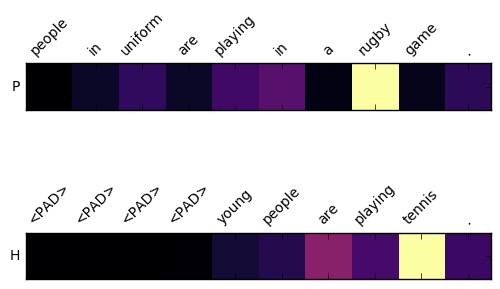

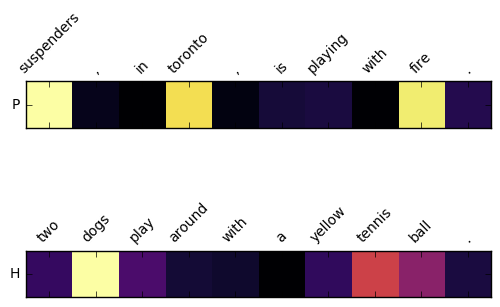

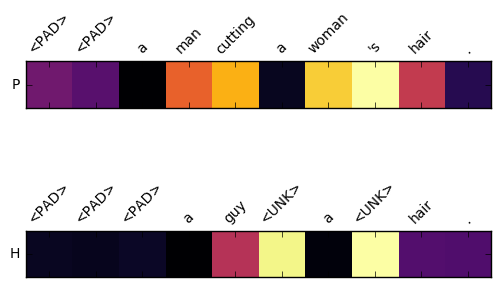

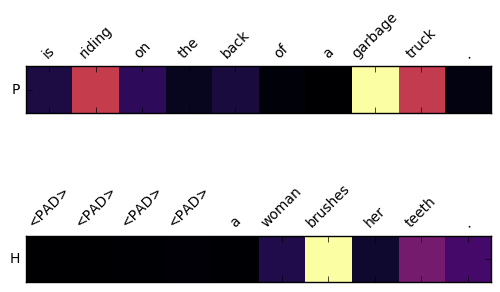

In [131]:
# Display the magnitudes
prem_gvs = np.vstack(prem_gvs)
hyp_gvs = np.vstack(hyp_gvs)
for i in range(len(examples)):    
    fig = plt.figure()
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)

    ax1.matshow([prem_gvs[:, i]], cmap=plt.cm.inferno)
    ax2.matshow([hyp_gvs[:, i]], cmap=plt.cm.inferno)

    premise_tokens = [indices_to_words[index] for index in examples[i]['sentence1_binary_parse_index_sequence']]
    hypothesis_tokens = [indices_to_words[index] for index in examples[i]['sentence2_binary_parse_index_sequence']]

    ax1.set_xticklabels(premise_tokens, rotation=45)
    ax2.set_xticklabels(hypothesis_tokens, rotation=45)
    ax1.set_yticklabels([None, 'P'])
    ax2.set_yticklabels([None, 'H'])

    ax1.set_xticks(np.arange(0, 10, 1.0))
    ax2.set_xticks(np.arange(0, 10, 1.0))
    ax1.set_xticks(np.arange(0, 10, 1.0))
    ax2.set_xticks(np.arange(0, 10, 1.0))